[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juanjoramirez01/Proyecto_IA_molecular/blob/main/PROYECTO_ENTREGA2.ipynb)

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanjoseramrezcuervo","key":"5b8e56ff9d5e3dd7f2c4d99ce79fb0fe"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c champs-scalar-coupling

100% 376M/377M [00:02<00:00, 187MB/s]
100% 377M/377M [00:02<00:00, 174MB/s]


In [ ]:
!unzip -o '/content/champs-scalar-coupling.zip'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: structures/dsgdb9nsd_128302.xyz  
  inflating: structures/dsgdb9nsd_128303.xyz  
  inflating: structures/dsgdb9nsd_128304.xyz  
  inflating: structures/dsgdb9nsd_128305.xyz  
  inflating: structures/dsgdb9nsd_128306.xyz  
  inflating: structures/dsgdb9nsd_128308.xyz  
  inflating: structures/dsgdb9nsd_128309.xyz  
  inflating: structures/dsgdb9nsd_128310.xyz  
  inflating: structures/dsgdb9nsd_128311.xyz  
  inflating: structures/dsgdb9nsd_128312.xyz  
  inflating: structures/dsgdb9nsd_128313.xyz  
  inflating: structures/dsgdb9nsd_128314.xyz  
  inflating: structures/dsgdb9nsd_128315.xyz  
  inflating: structures/dsgdb9nsd_128316.xyz  
  inflating: structures/dsgdb9nsd_128317.xyz  
  inflating: structures/dsgdb9nsd_128318.xyz  
  inflating: structures/dsgdb9nsd_128319.xyz  
  inflating: structures/dsgdb9nsd_128320.xyz  
  inflating: structures/dsgdb9nsd_128321.xyz  
  inflating: structures/dsgdb9nsd_128322

In [335]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import local.lib.timeseries as ts
from local.lib import calhousing as ch
%matplotlib inline

# Carga de datos de entranamiento

In [336]:
d1 = pd.read_csv('train.csv')
d1 = d1[:861379]
d1

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.80760
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.25700
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25480
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25430
4,4,dsgdb9nsd_000001,2,0,1JHC,84.80740
...,...,...,...,...,...,...
861374,861374,dsgdb9nsd_029999,16,4,2JHC,2.20243
861375,861375,dsgdb9nsd_029999,16,5,3JHC,8.13388
861376,861376,dsgdb9nsd_029999,16,6,3JHN,3.09138
861377,861377,dsgdb9nsd_029999,16,7,2JHC,7.16273


# Carga de datos de test

In [337]:
d2 = pd.read_csv('test.csv')
d2 = d2[:460452]
d2

,id,molecule_name,atom_index_0,atom_index_1,type
0,4659076,dsgdb9nsd_000004,2,0,2JHC
1,4659077,dsgdb9nsd_000004,2,1,1JHC
2,4659078,dsgdb9nsd_000004,2,3,3JHH
3,4659079,dsgdb9nsd_000004,3,0,1JHC
4,4659080,dsgdb9nsd_000004,3,1,2JHC
...,...,...,...,...,...
460447,5119523,dsgdb9nsd_030000,15,4,3JHC
460448,5119524,dsgdb9nsd_030000,15,5,3JHC
460449,5119525,dsgdb9nsd_030000,15,6,2JHN
460450,5119526,dsgdb9nsd_030000,15,7,1JHC


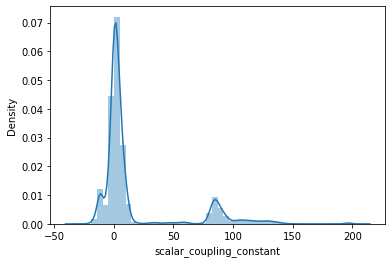

In [338]:
sns.distplot(d1['scalar_coupling_constant']);

# Carga de otros sets de datos para adjuntarlos al dataframe principal

In [339]:
dipole = pd.read_csv('dipole_moments.csv')
potential = pd.read_csv('potential_energy.csv')
scalar = pd.read_csv('scalar_coupling_contributions.csv')

# Reprocesamiento de los dataframes

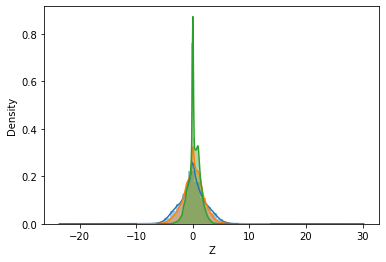

In [340]:
#Como se ve en las gráficas, gran parte de los valores de las tres columnas de momento dipolar son 0
#Por lo tanto se eliminan los datos iguales a 0 para que se cumpla con la condición de que 5% son NaN
sns.distplot(dipole['X']);
sns.distplot(dipole['Y']);
sns.distplot(dipole['Z']);

In [341]:
dipole['X'] = dipole['X'].replace(0, np.nan)
dipole['Y'] = dipole['Y'].replace(0, np.nan)
dipole['Z'] = dipole['Z'].replace(0, np.nan)

In [342]:
#Cambio de nombre de las columnas del archivo dipole_moments.csv
dipole.columns=['molecule_name','dipole_moment_X','dipole_moment_Y','dipole_moment_Z']
#Se adjuntan los datos de dipole_moments.csv y potential_energy.csv
dipole_and_potential = dipole.join(potential, rsuffix='other')
del dipole_and_potential['molecule_nameother']

In [343]:
#Se adjuntan los datos de la celda anterior con los de entrenamiento o test y luego con los de scalar
def formateo(d):
  d = d.set_index('molecule_name').join(dipole_and_potential.set_index('molecule_name'))
  d = d.set_index('id').join(scalar, rsuffix='other')
  del d['atom_index_0other']; del d['atom_index_1other']; del d['typeother']
  return d

In [344]:
#Conversión de variable categórica de tipo de molecula a variable numérica y designación de nuevas columnas
new_cols = ['atom_index_0', 'atom_index_1', 
       'type_1JHC', 'type_1JHN', 'type_2JHC', 'type_2JHH', 'type_2JHN',
       'type_3JHC', 'type_3JHH', 'type_3JHN', 'dipole_moment_X', 'dipole_moment_Y', 'dipole_moment_Z',
       'potential_energy', 'fc', 'sd', 'pso', 'dso']

def clean(d):
  d = formateo(d)
  d['type'].replace(['1JHC', '1JHN', '2JHC', '2JHH','2JHN', '3JHC', '3JHH', '3JHN'],
                        [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)
  simple_array = d['type'].values
  encoded_array = np.zeros((simple_array.size, simple_array.max()+1), dtype=int)
  encoded_array[np.arange(simple_array.size),simple_array] = 1
  print(encoded_array.shape)
  k = pd.DataFrame(encoded_array, columns=['type_1JHC', 'type_1JHN', 'type_2JHC',
      'type_2JHH', 'type_2JHN', 'type_3JHC', 'type_3JHH', 'type_3JHN'], index=d.index)
  d = d.join(k)
  del d['type']
  d = d.reindex(columns=new_cols)
  return d
  

In [345]:
d_train = clean(d1)
d_train

(861379, 8)


,atom_index_0,atom_index_1,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,dipole_moment_X,dipole_moment_Y,dipole_moment_Z,potential_energy,fc,sd,pso,dso
id,,,,,,,,,,,,,,,,,,
0,1,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,-40.523680,83.02240,0.254579,1.258620,0.272010
1,1,2,0,0,0,1,0,0,0,0,NaN,NaN,NaN,-40.523680,-11.03470,0.352978,2.858390,-3.433600
2,1,3,0,0,0,1,0,0,0,0,NaN,NaN,NaN,-40.523680,-11.03250,0.352944,2.858520,-3.433870
3,1,4,0,0,0,1,0,0,0,0,NaN,NaN,NaN,-40.523680,-11.03190,0.352934,2.858550,-3.433930
4,2,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,-40.523680,83.02220,0.254585,1.258610,0.272013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861374,16,4,0,0,1,0,0,0,0,0,1.6195,-2.959,0.0015,-381.049649,2.75974,0.067778,-0.392869,-0.232218
861375,16,5,0,0,0,0,0,1,0,0,1.6195,-2.959,0.0015,-381.049649,8.42077,-0.056647,0.221875,-0.452118
861376,16,6,0,0,0,0,0,0,0,1,1.6195,-2.959,0.0015,-381.049649,3.13564,0.031592,0.081915,-0.157767


In [346]:
d_test = clean(d2)
d_test

(460452, 8)


,atom_index_0,atom_index_1,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,dipole_moment_X,dipole_moment_Y,dipole_moment_Z,potential_energy,fc,sd,pso,dso
id,,,,,,,,,,,,,,,,,,
4659076,2,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,-77.335268,NaN,NaN,NaN,NaN
4659077,2,1,1,0,0,0,0,0,0,0,NaN,NaN,NaN,-77.335268,NaN,NaN,NaN,NaN
4659078,2,3,0,0,0,0,0,0,1,0,NaN,NaN,NaN,-77.335268,NaN,NaN,NaN,NaN
4659079,3,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,-77.335268,NaN,NaN,NaN,NaN
4659080,3,1,0,0,1,0,0,0,0,0,NaN,NaN,NaN,-77.335268,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119523,15,4,0,0,0,0,0,1,0,0,-3.0275,-4.2869,0.0018,-397.094264,NaN,NaN,NaN,NaN
5119524,15,5,0,0,0,0,0,1,0,0,-3.0275,-4.2869,0.0018,-397.094264,NaN,NaN,NaN,NaN
5119525,15,6,0,0,0,0,1,0,0,0,-3.0275,-4.2869,0.0018,-397.094264,NaN,NaN,NaN,NaN


In [347]:
for i in d_train.columns:
    print ("%20s"%i, np.sum(d_train[i].isna()))

        atom_index_0 0
        atom_index_1 0
           type_1JHC 0
           type_1JHN 0
           type_2JHC 0
           type_2JHH 0
           type_2JHN 0
           type_3JHC 0
           type_3JHH 0
           type_3JHN 0
     dipole_moment_X 14770
     dipole_moment_Y 25599
     dipole_moment_Z 43308
    potential_energy 0
                  fc 0
                  sd 0
                 pso 0
                 dso 0


In [348]:
X = d_train.values
y = d1["scalar_coupling_constant"].values

In [349]:
#En las columnas que contienen nan, los nan fueron reemplazados por el promedio de la columna
X[:,10] = np.nan_to_num(X[:,10], nan=np.nanmean(X[:,10]))
X[:,11] = np.nan_to_num(X[:,11], nan=np.nanmean(X[:,11]))
X[:,12] = np.nan_to_num(X[:,12], nan=np.nanmean(X[:,12]))

In [350]:
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(602965, 18) (602965,) (258414, 18) (258414,)


In [351]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error

In [352]:
lr = LinearRegression()
lr.fit(Xtr, ytr)
lr.score(Xtr, ytr), lr.score(Xts, yts)

(0.9999999999940867, 0.9999999999941527)

In [353]:
r2_score(yts, lr.predict(Xts))

0.9999999999941527

In [354]:
median_absolute_error(yts, lr.predict(Xts))

3.7010742541809805e-06

In [355]:
mean_squared_error(yts, lr.predict(Xts))

7.63572474850464e-09

# Mean Absolute Error

In [356]:
def rel_mrae(estimator, X, y):
    preds = estimator.predict(X)
    return np.mean(np.abs(preds-y)/y)

In [357]:
rel_mrae(lr, Xtr, ytr), rel_mrae(lr, Xts, yts)

(-8.739101209567051e-08, 6.246302925789865e-07)

In [358]:
preds = lr.predict(Xts)
errors = np.abs(preds-yts)/yts

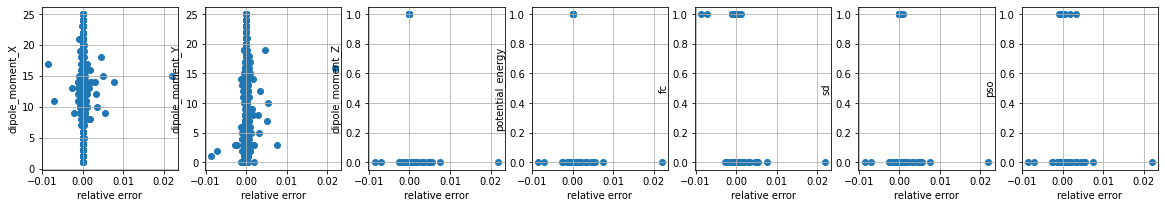

In [359]:
plt.figure(figsize=(20,3))
cols = new_cols[10:-1]
for i,col in enumerate(cols):
    plt.subplot(1,len(cols),i+1)
    plt.scatter(errors, Xts[:,i])
    plt.ylabel(col)
    plt.xlabel("relative error")
    plt.grid();

In [360]:
corrcoefs = pd.DataFrame([np.corrcoef(Xts[:,i], errors)[0,1] for i in range(len(cols))], index=cols, columns=["corrcoef"])
corrcoefs


,corrcoef
dipole_moment_X,0.003128
dipole_moment_Y,0.004757
dipole_moment_Z,0.003296
potential_energy,0.000178
fc,-0.012588
sd,-0.014417
pso,0.001736


In [361]:
from progressbar import progressbar as pbar

def bootstrap_score(estimator, X, y, test_size):
  trscores, tsscores = [], []
  for _ in range(10):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    estimator.fit(Xtr, ytr)
    trscores.append(rel_mrae(estimator, Xtr, ytr))
    tsscores.append(rel_mrae(estimator, Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

In [362]:
estimator = LinearRegression()
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, X, y, test_size=0.3)
print ("train score %.3f (±%.4f)"%(trmean, trstd))
print ("test score  %.3f (±%.4f)"%(tsmean, tsstd))

train score 0.000 (±0.0000)
test score  0.000 (±0.0000)


In [363]:
from sklearn.model_selection import ShuffleSplit, KFold,cross_val_score
ss = ShuffleSplit(n_splits=3, test_size=0.3)

for a,b in ss.split(range(10)):
    print (a, b)

[8 6 2 4 3 1 9] [0 5 7]
[0 2 7 8 3 9 1] [6 4 5]
[5 6 4 2 8 1 9] [0 3 7]


In [364]:
z = cross_val_score(lr, X, y, cv = ShuffleSplit(n_splits=10, test_size=0.3), scoring=rel_mrae)
print (z)
print ("test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))

[-3.91957326e-07  8.65686396e-07  5.92006225e-07 -7.61951138e-08
  1.24847808e-06  4.82532602e-07  7.01710788e-07  8.23490143e-07
  1.30103090e-06  1.38187735e-07]
test score  0.000 (±0.0000)


In [365]:
ss = KFold(n_splits=3)

for a,b in ss.split(range(10)):
    print (a, b)

[4 5 6 7 8 9] [0 1 2 3]
[0 1 2 3 7 8 9] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]


In [366]:
z = cross_val_score(lr, X, y, cv = KFold(n_splits=10), scoring=rel_mrae)
print (z)
print ("test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))

[ 6.03071813e-07 -1.11445409e-06  3.66358202e-07  2.57379259e-07
  3.42350908e-07  6.69182036e-07  1.44701920e-07  4.94580841e-07
  8.50187099e-08  4.92286793e-07]
test score  0.000 (±0.0000)


In [367]:
from sklearn.model_selection import ShuffleSplit

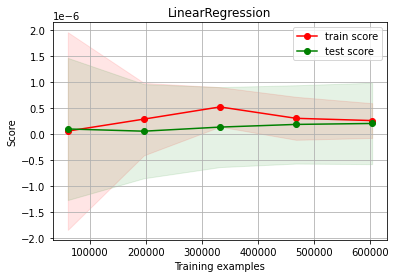

In [368]:
cv = ShuffleSplit(n_splits=10, test_size=.3)

ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, 
                       cv=cv, scoring=rel_mrae)

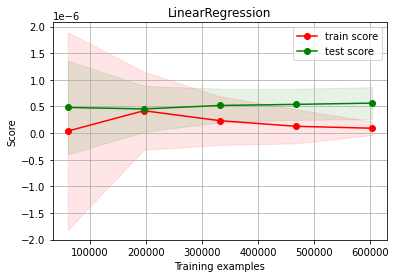

In [369]:
estimator = LinearRegression()
cv = ShuffleSplit(n_splits=10, test_size=.3)
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae)

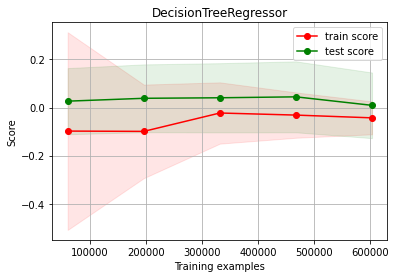

In [370]:
from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor(max_depth=8)
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae)

In [371]:
# from sklearn.ensemble import RandomForestRegressor
# estimator = RandomForestRegressor(max_depth=2)
# (trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, X, y, test_size=0.3)
# print ("train score %.3f (±%.4f)"%(trmean, trstd))
# print ("test score  %.3f (±%.4f)"%(tsmean, tsstd))

In [372]:
from sklearn.model_selection import cross_validate, ShuffleSplit

In [373]:
estimator1 = DecisionTreeRegressor(max_depth=5)
z1 = cross_validate(estimator1, X, y, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))

test score   0.074 (±0.3473) with 10 splits
train score  0.219 (±0.0394) with 10 splits


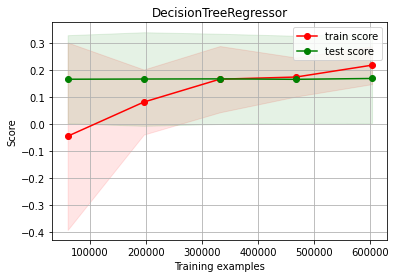

In [374]:
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))
    
report_cv_score(z1)    
ch.plot_learning_curve(estimator1, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
estimator2 = DecisionTreeRegressor(max_depth=10)
z2 = cross_validate(estimator2, X, y, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))  
report_cv_score(z2)    
ch.plot_learning_curve(estimator2, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae)

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
Xp = pca.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=.3)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
dt = GaussianNB()
dt.fit(Xtr, ytr)
dt.score(Xtr, ytr), dt.score(Xts, yts)

In [ ]:
cs = range(10,200,5)
dtr, dts = [], []
for n_components in cs:
    print (".", end="")
    pca = PCA(n_components=n_components)
    pca.fit(Xtr)

    Xt_tr = pca.transform(Xtr)
    Xt_ts = pca.transform(Xts)

    dt.fit(Xt_tr,ytr)
    ypreds_tr = dt.predict(Xt_tr)
    ypreds_ts = dt.predict(Xt_ts)
    ypreds_tr.shape, ypreds_ts.shape
    dtr.append(np.mean(ytr==ypreds_tr))
    dts.append(np.mean(yts==ypreds_ts))

In [ ]:
plt.plot(cs, dtr, label="train")
plt.plot(cs, dts, label="test")
plt.xlabel("n components")
plt.ylabel("% acierto")
plt.legend()